In [ ]:
import csv
import os
import shutil

This block generates a csv file of the destination of our images saved in Google Drive and also creates a Indian(1) or non-Indian(0) column along with it as the images have been kept in different folders.

In [ ]:
with open('combine_images.csv', 'w') as file:
  writer = csv.writer(file)
  writer.writerow(['Name','Result'])

  for i in os.listdir('/content/drive/MyDrive/Images/indian'):
    writer.writerow(['/content/drive/MyDrive/Images/indian/'+i,1])
  for j in os.listdir('/content/drive/MyDrive/Images/non'):
    writer.writerow(['/content/drive/MyDrive/Images/non/'+j , 0])

In [ ]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC



We load the csv file to dataframe and shuffle it.

In [ ]:
df = pd.read_csv('/content/combine_images.csv')
from sklearn.utils import shuffle
df

,Name,Result
0,/content/drive/MyDrive/Images/indian/image 385...,1
1,/content/drive/MyDrive/Images/indian/image 385...,1
2,/content/drive/MyDrive/Images/indian/image 384...,1
3,/content/drive/MyDrive/Images/indian/image 381...,1
4,/content/drive/MyDrive/Images/indian/image 389...,1
...,...,...
2437,/content/drive/MyDrive/Images/non/image_non_in...,0
2438,/content/drive/MyDrive/Images/non/image_non_in...,0
2439,/content/drive/MyDrive/Images/non/image_non_in...,0
2440,/content/drive/MyDrive/Images/non/image_non_in...,0


In [ ]:
df = shuffle(df)
df

,Name,Result
1806,/content/drive/MyDrive/Images/non/image_non_in...,0
1886,/content/drive/MyDrive/Images/non/image_non_in...,0
2017,/content/drive/MyDrive/Images/non/image_non_in...,0
313,/content/drive/MyDrive/Images/indian/image 609...,1
962,/content/drive/MyDrive/Images/indian/image 753...,1
...,...,...
1606,/content/drive/MyDrive/Images/indian/image 245...,1
844,/content/drive/MyDrive/Images/indian/image 698...,1
469,/content/drive/MyDrive/Images/indian/image 198...,1
1462,/content/drive/MyDrive/Images/indian/image 150...,1


This is a dubugging block and does not contribute to working of model.

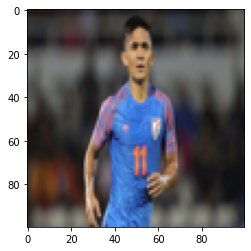

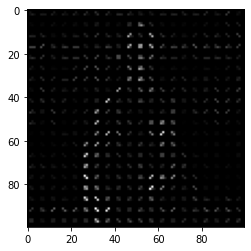

In [ ]:
file_path = df[df.Result==1].Name[400]
# 600
img = Image.open('/content/Sunil-Chhetri.webp')
img = img.resize((100,100))
img_arr = np.array(img)
plt.imshow(np.array(img))
plt.show()
grey_image = rgb2grey(img_arr)
grey_image
hog_features, hog_image = hog(grey_image,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(5, 5))

plt.imshow(hog_image, cmap=mpl.cm.gray)



This function receives destination of image as a parameter and then it extracts HOG and Color features from image and combine them to a singe array.

In [ ]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(5, 5))
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features , hog_features))
    return flat_features
#a=create_features(img_arr)
#a.size

This function iters over all the image destination and performs the create_features function on each of them and then returns a matrix with features of all images.

In [ ]:
def create_feature_matrix(dataframe):
    features_list = []
    a=1
    for img_name in dataframe.Name:
        # load image
        img = Image.open(img_name)
        try:
          img = img.resize((100,100))
        except:
          continue
        img_arr = np.array(img)
        # get features for image
        image_features = create_features(img_arr)
        features_list.append(image_features)
        print(a)
        a= a+1

    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(df)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


Scaling of the matrix

In [ ]:
# get shape of feature matrix d
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
scaled_features = ss.fit_transform(feature_matrix)

Feature matrix shape is:  (2442, 56244)


Scaled Matrix is given as feature and result column of dataframe is given a label

In [ ]:
X = pd.DataFrame(scaled_features)
y = pd.Series(df.Result.values)
y.shape

(2442,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2, random_state=0
                                                    )


In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression( max_iter= 1200)
lr.fit(X_train,y_train)
lr.score(X_test , y_test)

0.7648261758691206

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier(n_neighbors=7, metric='euclidean')
knn.fit(X_train , y_train)
knn.score(X_test , y_test)

0.7341513292433538

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=0)
dtc.fit(X_train,y_train)
dtc.score(X_test,y_test)

0.7341513292433538

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc=RandomForestClassifier(random_state=0)
rfc.fit(X_train,y_train)
rfc.score(X_test,y_test)

0.7627811860940695

Now using the model to predict images of our test folder.

In [ ]:
test_list = os.listdir('/content/drive/MyDrive/Images/test')
len(test_list)

1681

In [ ]:
for temp in os.listdir('/content/positive'):
  os.remove('/content/positive/' + temp)


In [ ]:
def find_single_prediction(img_list):
    features_list = []

        # load image
    a=1
    for img_name in img_list:
        # load image
        #img = Image.open('/content/download (1).jpg')

        img = Image.open('/content/drive/MyDrive/Images/test/' + img_name)
        try:
          img = img.resize((100,100))
        except:
          continue
        img_arr = np.array(img)
        # get features for image
        image_features = create_features(img_arr)
        features_list.append(image_features)
        #print(a)
        a= a+1

    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    ss = StandardScaler()
# run this on our feature matrix
    scaled_features = ss.fit_transform(feature_matrix)


    img_input = ss.fit_transform(scaled_features)
    '''print(  lr.predict(img_input)  )
    print( knn.predict(img_input)  )
    print( svm.predict(img_input)  )
    print(  dtc.predict(img_input))
    print( rfc.predict(img_input))'''
    predy = rfc.predict(img_input)
    list_pred = list(predy)
    for index , j in enumerate(list_pred):
        if j == 1:
          image_dest = test_list[index]
          src = '/content/drive/MyDrive/Images/test/' + image_dest
          shutil.copyfile(src , '/content/positive/' + image_dest)
          #print(index)'''
    return predy


In [ ]:
qwe = find_single_prediction(os.listdir('/content/drive/MyDrive/Images/test'))

In [ ]:
qwe

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
len(os.listdir('/content/positive'))

0

Function for testing single image..

In [ ]:
def single(single_img_path):
    features_list = []
    img = Image.open(single_img_path)

    try:
          img = img.resize((100,100))
    except:
          pass
    img_arr = np.array(img)
        # get features for image
    image_features = create_features(img_arr)
    features_list.append(image_features)
    #print(a)
    #a= a+1

    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    ss = StandardScaler()
# run this on our feature matrix
    scaled_features = ss.fit_transform(feature_matrix)


    img_input = ss.fit_transform(scaled_features)
    return rfc.predict(img_input)

In [ ]:
anss = single('/content/Sunil-Chhetri.webp')
anss

array([1])